<a href="https://colab.research.google.com/github/jessalynlc/IDS705_final_project/blob/main/data_scrape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time
import requests
import json
import pandas as pd
import numpy as np

In [4]:
%reset -f


# 1. Data Preparation

In [ ]:
api_key = 'd70a0d83e1a942578e16b2ed70dab42f'

#pulling data for ERCOT
ercot_load_forecast_dam = 'https://api.gridstatus.io/v1/datasets/ercot_load_forecast_dam/query?api_key=' + api_key + '&limit=1000'
load = 'https://api.gridstatus.io/v1/datasets/ercot_load/query?api_key=' + api_key + '&limit=1000'
ercot_unplanned_resource_outages = 'https://api.gridstatus.io/v1/datasets/ercot_unplanned_resource_outages/query?api_key=' + api_key + '&limit=1000'
ercot_fuel_mix = 'https://api.gridstatus.io/v1/datasets/ercot_fuel_mix/query?api_key=' + api_key + '&limit=1000'
ercot_solar_actual_and_forecast_hourly = 'https://api.gridstatus.io/v1/datasets/ercot_solar_actual_and_forecast_hourly/query?api_key=' + api_key + '&limit=1000'
ercot_temperature_forecast_by_weather_zone = 'https://api.gridstatus.io/v1/datasets/ercot_temperature_forecast_by_weather_zone/query?api_key=' + api_key + '&limit=1000'
ercot_energy_storage_resources = 'https://api.gridstatus.io/v1/datasets/ercot_energy_storage_resources/query?api_key=' + api_key + '&limit=1000'


#LMP price pull (target)
#Pulling LMP at the average of all the hubs
ercot_lmp_by_settlement_point = 'https://api.gridstatus.io/v1/datasets/ercot_lmp_by_settlement_point/query/location/HB_HUBAVG?api_key=' + api_key + '&limit=1000'

#Other hubs incase we want to forecast them, but sticking with the bus average:HB_CENTRAL, HB_EAST, HB_HOUSTON, HB_BUSAVG, HB_NORTH, HB_PAN, HB_SOUTH HB_WEST

## Data Pull V1

In [ ]:
WAIT_TIME = 1  # seconds

response = requests.get(ercot_load_forecast_dam)
ercot_load_forecast_dam_data = response.json()
time.sleep(WAIT_TIME)

response = requests.get(load)
load_data = response.json()
time.sleep(WAIT_TIME)

response = requests.get(ercot_unplanned_resource_outages)
ercot_unplanned_resource_outages_data = response.json()
time.sleep(WAIT_TIME)

response = requests.get(ercot_fuel_mix)
ercot_fuel_mix_data = response.json()
time.sleep(WAIT_TIME)

response = requests.get(ercot_solar_actual_and_forecast_hourly)
ercot_solar_actual_and_forecast_hourly_data = response.json()
time.sleep(WAIT_TIME)

response = requests.get(ercot_temperature_forecast_by_weather_zone)
ercot_temperature_forecast_by_weather_zone_data = response.json()
time.sleep(WAIT_TIME)

response = requests.get(ercot_energy_storage_resources)
ercot_energy_storage_resources_data = response.json()
time.sleep(WAIT_TIME)

response = requests.get(ercot_lmp_by_settlement_point)
ercot_lmp_by_settlement_point_data = response.json()

#Question: Not all the datasets start at the same time, but I almost wonder if it's interesting to see how the model performs as more data gets added as time progresses...

### Organizing data frame

In [ ]:
#extracting the value of the data key to create a list of dictionaries
ercot_load_forecast_dam_records = ercot_load_forecast_dam_data['data']
load_records = load_data['data']
ercot_unplanned_resource_outages_records = ercot_unplanned_resource_outages_data['data']
ercot_fuel_mix_records = ercot_fuel_mix_data['data']
ercot_solar_actual_and_forecast_hourly_records = ercot_solar_actual_and_forecast_hourly_data['data']
ercot_temperature_forecast_by_weather_zone_records = ercot_temperature_forecast_by_weather_zone_data['data']
ercot_energy_storage_resources_records = ercot_energy_storage_resources_data['data']
ercot_lmp_by_settlement_point_records = ercot_lmp_by_settlement_point_data['data']

# Create separate data frames
ercot_load_forecast_dam_df = pd.DataFrame(ercot_load_forecast_dam_records)
load_df = pd.DataFrame(load_records)
ercot_unplanned_resource_outages_df = pd.DataFrame(ercot_unplanned_resource_outages_records)
ercot_fuel_mix_df = pd.DataFrame(ercot_fuel_mix_records)
ercot_solar_actual_and_forecast_hourly_df = pd.DataFrame(ercot_solar_actual_and_forecast_hourly_records)
ercot_temperature_forecast_by_weather_zone_df = pd.DataFrame(ercot_temperature_forecast_by_weather_zone_records)
ercot_energy_storage_resources_df = pd.DataFrame(ercot_energy_storage_resources_records)
ercot_lmp_by_settlement_point_records_df = pd.DataFrame(ercot_lmp_by_settlement_point_records)

# Put all DataFrames in a list
dataframes = [
    ercot_load_forecast_dam_df,
    load_df,
    #ercot_unplanned_resource_outages_df, commenting out for now, have to think about how to add this to master
    ercot_fuel_mix_df,
    ercot_solar_actual_and_forecast_hourly_df,
    ercot_temperature_forecast_by_weather_zone_df,
    ercot_energy_storage_resources_df,
    ercot_lmp_by_settlement_point_records_df
]

#Standardize timestamps and collect time deltas
min_intervals = []
for i in range(len(dataframes)):
  df = dataframes[i].copy()

  # Rename time_utc to interval_start_utc if present, I think this is only for ercot_temperature_forecast_by_weather_zone_df
  if 'time_utc' in df.columns:
    df = df.rename(columns={'time_utc': 'interval_start_utc'})

  # Convert timestamps
  df['interval_start_utc'] = pd.to_datetime(df['interval_start_utc'])

  # Convert and inspect time delta if end time exists
  if 'interval_end_utc' in df.columns:
    df['interval_end_utc'] = pd.to_datetime(df['interval_end_utc'])
    deltas = (df['interval_end_utc'] - df['interval_start_utc']).dropna()
    if not deltas.empty:
      min_intervals.append(deltas.min())

  dataframes[i] = df

#Find smallest interval (e.g., 5 minutes)
smallest_interval = min(min_intervals)
print(f"Smallest interval detected: {smallest_interval}")

#Create master time index
all_times = pd.concat([df['interval_start_utc'] for df in dataframes])
time_index = pd.date_range(start=all_times.min(), end=all_times.max(), freq=smallest_interval)
master_df = pd.DataFrame({'interval_start_utc': time_index})

#Drop original interval_end_utc and merge
for df in dataframes:
    if 'interval_end_utc' in df.columns:
        df = df.drop(columns='interval_end_utc')
    master_df = master_df.merge(df, on='interval_start_utc', how='left')

#Add consistent interval_end_utc
master_df['interval_end_utc'] = master_df['interval_start_utc'] + smallest_interval

print(master_df.head())
print(master_df.shape)

## DATA PULL V2 (FINAL)

Data pull for all are hourly and spans Jan 1 2018 - April 12, 2025

In [ ]:
#RT load data
load_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/ercot_load_by_forecast_zone.csv"

#RT LMP data
busavg_1_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/HB_BUSAVG_LMP_Jan12018-Jan12019.csv"
busavg_2_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/HB_BUSAVG_LMP_Jan12019-Jan12020.csv"
busavg_3_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/HB_BUSAVG_LMP_Jan12020-Dec312020.csv"
busavg_4_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/HB_BUS_AVG_LMP_Dec312020-Dec312021.csv"
busavg_5_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/HB_BUS_AVG_LMP_Dec312021-Dec312022.csv"
busavg_6_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/HB_BUS_AVG_LMP_Dec312022-Dec312023.csv"
#don't forget to delete Dec 30 data from here because it's in last data file!
busavg_7_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/HB_BUS_AVG_LMP_Dec302023-Dec292024.csv"
busavg_8_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/HB_BUS_AVG_LMP_Dec292024_Apr132025.csv"

#fuel mix data
fuelmix_1_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/fuel_mix_Jan12018-Jan12019.csv"
fuelmix_2_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/fuel_mix_Jan12019-Jan12020.csv"
fuelmix_3_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/fuel_mix_Jan12020_Dec312020.csv"
fuelmix_4_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/fuel_mix_Dec312020_Dec312021.csv"
fuelmix_5_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/fuel_mix_Dec312021-Dec312022.csv"
fuelmix_6_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/fuel_mix_Dec312022-Dec312023.csv"
fuelmix_7_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/fuel_mix_Dec312023-Dec302024.csv"
fuelmix_8_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/fuel_mix_Dec302024-Apr132025.csv"

#temp data
temp_1_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/temp_Jan12018-Jan12019.csv"
temp_2_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/temp_Jan12019-Jan12020.csv"
temp_3_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/temp_Jan12020-Dec312020.csv"
temp_4_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/temp_Dec312020-Dec312021.csv"
temp_5_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/temp_Dec312021-Dec312022.csv"
temp_6_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/temp_Dec312022-Dec312023.csv"
temp_7_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/temp_Dec312023-Dec302024_v2.csv"
temp_8_url = "https://raw.githubusercontent.com/jessalynlc/IDS705_final_project/main/Raw_Data/temp_Dec302024-Apr132025.csv"


In [ ]:
load = pd.read_csv(load_url)

busavg_1 = pd.read_csv(busavg_1_url)
busavg_2 = pd.read_csv(busavg_2_url)
busavg_3 = pd.read_csv(busavg_3_url)
busavg_4 = pd.read_csv(busavg_4_url)
busavg_5 = pd.read_csv(busavg_5_url)
busavg_6 = pd.read_csv(busavg_6_url)
busavg_7 = pd.read_csv(busavg_7_url)
busavg_8 = pd.read_csv(busavg_8_url)

fuelmix_1 = pd.read_csv(fuelmix_1_url)
fuelmix_2 = pd.read_csv(fuelmix_2_url)
fuelmix_3 = pd.read_csv(fuelmix_3_url)
fuelmix_4 = pd.read_csv(fuelmix_4_url)
fuelmix_5 = pd.read_csv(fuelmix_5_url)
fuelmix_6 = pd.read_csv(fuelmix_6_url)
fuelmix_7 = pd.read_csv(fuelmix_7_url)
fuelmix_8 = pd.read_csv(fuelmix_8_url)

temp_1 = pd.read_csv(temp_1_url)
temp_2 = pd.read_csv(temp_2_url)
temp_3 = pd.read_csv(temp_3_url)
temp_4 = pd.read_csv(temp_4_url)
temp_5 = pd.read_csv(temp_5_url)
temp_6 = pd.read_csv(temp_6_url)
temp_7 = pd.read_csv(temp_7_url)
temp_8 = pd.read_csv(temp_8_url)


In [ ]:
#combining csv files

#cleaning this file because have an overlapping day
busavg_7_temp = busavg_7.drop(index=range(24))
busavg_lmp = pd.concat([busavg_1, busavg_2, busavg_3, busavg_4, busavg_5, busavg_6, busavg_7_temp, busavg_8])

fuel_mix = pd.concat([fuelmix_1, fuelmix_2, fuelmix_3, fuelmix_4, fuelmix_5, fuelmix_6, fuelmix_7, fuelmix_8])

temp = pd.concat([temp_1, temp_2, temp_3, temp_4, temp_5, temp_6, temp_7, temp_8])

In [ ]:
#num of rows should match

#not really sure why load is missing data, so i'm just going to fill.NA later to simplify, could be worth looking into issue later
print(load.shape)
print(busavg_lmp.shape)
print(fuel_mix.shape)
print(temp.shape)

#load.to_csv('load.csv', index=False)

In [ ]:
load.head()

In [ ]:
#busavg_lmp.head()

In [ ]:
#fuel_mix.head()

In [ ]:
#temp.head()

In [ ]:
#dropping unnecessary columns
load = load.drop(columns=['interval_end_local', 'interval_start_local', 'interval_end_utc'])
busavg_lmp = busavg_lmp.drop(columns=['interval_end_local', 'interval_start_local', 'interval_end_utc', 'location'])
fuel_mix = fuel_mix.drop(columns=['interval_end_local', 'interval_start_local', 'interval_end_utc'])
temp = temp.drop(columns=['interval_end_local', 'interval_start_local', 'interval_end_utc', 'publish_time_local', 'publish_time_utc'])

#turning interval_start_local to datetime objects
for df in [load, busavg_lmp, fuel_mix, temp]:
    df['interval_start_utc'] = pd.to_datetime(df['interval_start_utc'], utc = True)


In [ ]:
merged = load.merge(busavg_lmp, on='interval_start_utc', how='left')
merged = merged.merge(fuel_mix, on='interval_start_utc', how='left')
all_hourly_data = merged.merge(temp, on='interval_start_utc', how='left')

In [ ]:
all_hourly_data.head()

In [ ]:
# First, convert to datetime (if not already)
#all_hourly_data['interval_start_utc'] = pd.to_datetime(all_hourly_data['interval_start_utc'])

all_hourly_data['interval_start_local'] = all_hourly_data['interval_start_utc'].dt.tz_convert('America/Chicago')

# Extract date and hour
all_hourly_data['date'] = all_hourly_data['interval_start_local'].dt.date
all_hourly_data['hour'] = all_hourly_data['interval_start_local'].dt.hour

In [ ]:
all_hourly_data = all_hourly_data.drop(columns=['interval_start_utc'])

In [ ]:
cols = ['interval_start_local', 'date', 'hour'] + [col for col in all_hourly_data.columns if col not in ['interval_start_local', 'date', 'hour']]
all_hourly_data = all_hourly_data[cols]

In [ ]:
all_hourly_data.head()

In [ ]:
# all_hourly_data.to_csv('all_hourly_data.csv', index = False)

# 2. Feature Engineering

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取数据
df = pd.read_csv('all_hourly_data.csv')

## 2.1 Target Variable

C:\Users\butterfly\AppData\Local\Temp\ipykernel_2704\2245626984.py:8: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['interval_start_local'] = pd.to_datetime(df['interval_start_local'])


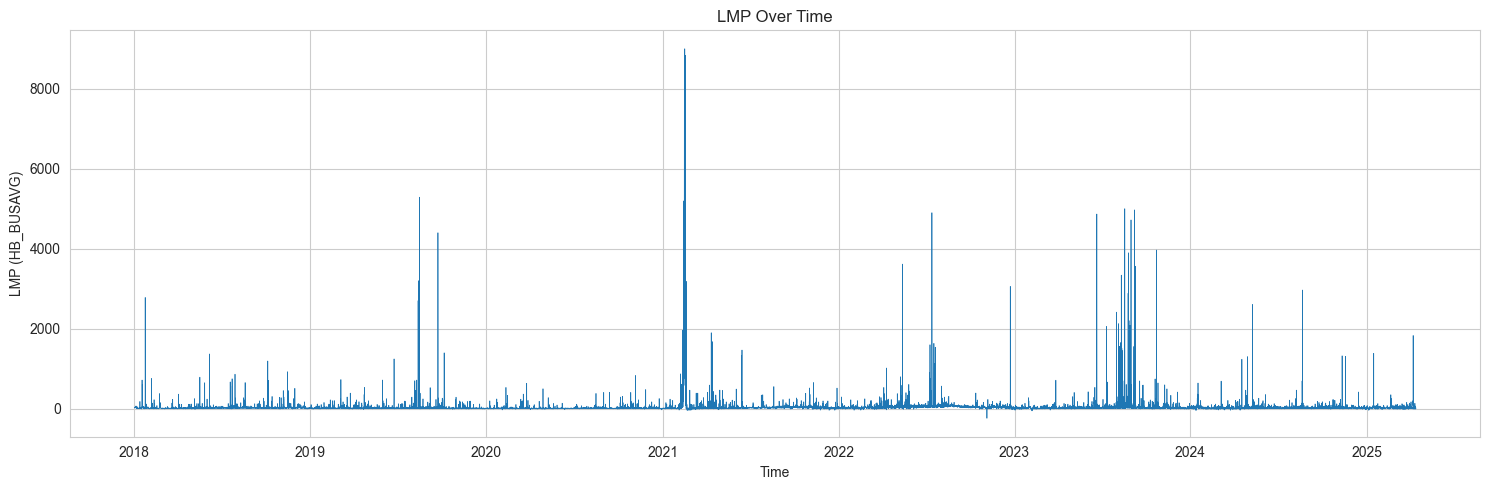

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

#
df = pd.read_csv('all_hourly_data.csv')

#
df['interval_start_local'] = pd.to_datetime(df['interval_start_local'])

#
df = df.sort_values('interval_start_local')

#
plt.figure(figsize=(15, 5))
plt.plot(df['interval_start_local'], df['lmp_HB_BUSAVG'], linewidth=0.5)
plt.xlabel('Time')
plt.ylabel('LMP (HB_BUSAVG)')
plt.title('LMP Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from statsmodels.tsa.stattools import adfuller

#
series = df['lmp_HB_BUSAVG']

#
result = adfuller(series, maxlag=12, regression='c')  #

print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value:        {result[1]:.4f}")
for key, value in result[4].items():
    print(f"Critical Value ({key}): {value:.4f}")


In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

#
series = df['lmp_HB_BUSAVG'].dropna()

#
plt.figure()
plot_acf(series, lags=50)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('ACF of lmp_HB_BUSAVG')
plt.tight_layout()
plt.show()

#
plt.figure()
plot_pacf(series, lags=50)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('PACF of lmp_HB_BUSAVG')
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(df['lmp_HB_BUSAVG'], bins=100, color='skyblue', edgecolor='black')
plt.xlabel('LMP (HB_BUSAVG)')
plt.ylabel('Frequency')
plt.title('Distribution of LMP')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

# 读取数据
df = pd.read_csv('all_hourly_data.csv')

# 提取目标变量
lmp = df['lmp_HB_BUSAVG']

# 计算统计量
mean_val = lmp.mean()
median_val = lmp.median()
std_val = lmp.std()
skew_val = skew(lmp)
kurt_val = kurtosis(lmp)  # Fisher's definition (normal dist = 0)

# 打印统计量
print(f"✅ LMP Summary Statistics:")
print(f"Mean: {mean_val:.2f}")
print(f"Median: {median_val:.2f}")
print(f"Standard Deviation: {std_val:.2f}")
print(f"Skewness: {skew_val:.2f}")
print(f"Kurtosis: {kurt_val:.2f}")

# 分布图
plt.figure(figsize=(10, 5))
sns.histplot(lmp, bins=100, kde=True, color='skyblue')
plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='green', linestyle='--', label=f'Median: {median_val:.2f}')
plt.xlabel('LMP (HB_BUSAVG)')
plt.ylabel('Frequency')
plt.title('Distribution of LMP')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 2.1.1 Log Transformation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 读取数据
df = pd.read_csv('all_hourly_data.csv')

# 转换时间格式，确保正确排序
df['interval_start_local'] = pd.to_datetime(df['interval_start_local'])
df = df.sort_values('interval_start_local')

# 对 LMP 进行对数变换（注意加 1 避免 log(0) 的情况）
df['lmp_log'] = np.log(df['lmp_HB_BUSAVG'] + 1)

# 绘制变换后的 LMP 随时间变化趋势图
plt.figure(figsize=(15, 5))
plt.plot(df['interval_start_local'], df['lmp_log'], linewidth=0.8, label='Log(lmp + 1)')
plt.xlabel('Time')
plt.ylabel('Log(LMP + 1)')
plt.title('Trend')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 2.2 Feature Engineering

In [12]:
import pandas as pd
import numpy as np

#
df = pd.read_csv('all_hourly_data.csv')

#
df['interval_start_local'] = pd.to_datetime(df['interval_start_local'], utc=True)


df['day_of_week']  = df['interval_start_local'].dt.dayofweek  #
df['day_of_month'] = df['interval_start_local'].dt.day       #
df['month']        = df['interval_start_local'].dt.month     #


# Lag Features
for lag in [1, 2, 3, 24, 48]:
    df[f'lmp_lag_{lag}'] = df['lmp_HB_BUSAVG'].shift(lag)

# Rolling Features
df['lmp_roll_mean_24'] = df['lmp_HB_BUSAVG'].rolling(window=24).mean()
df['lmp_roll_mean_48'] = df['lmp_HB_BUSAVG'].rolling(window=48).mean()
df['lmp_roll_mean_168'] = df['lmp_HB_BUSAVG'].rolling(window=168).mean()


#
df = df.dropna().reset_index(drop=True)


In [ ]:
#
print(df.isnull().sum())

## 2.3 Train-test Split

In [13]:
import pandas as pd


train_start = pd.Timestamp('2018-01-08 06:00:00+0000', tz='UTC')
train_end   = pd.Timestamp('2023-12-31 23:59:59+0000', tz='UTC')
test_start  = pd.Timestamp('2024-01-01 00:00:00+0000', tz='UTC')
test_end    = pd.Timestamp('2025-04-13 04:00:00+0000', tz='UTC')



#
mask_train = (df['interval_start_local'] >= train_start) & (df['interval_start_local'] <= train_end)
mask_test  = (df['interval_start_local'] >= test_start)  & (df['interval_start_local'] <= test_end)

#
train_df = df.loc[mask_train].reset_index(drop=True)
test_df  = df.loc[mask_test].reset_index(drop=True)

#
print(f"训练集样本数：{train_df.shape[0]}，特征数：{train_df.shape[1]}")
print(f"测试集样本数：{test_df.shape[0]}，特征数：{test_df.shape[1]}")


训练集样本数：52349，特征数：36
测试集样本数：11166，特征数：36


# 3.Boosting

## 3.1 Xgboost

### 3.1.1 RMSE

In [14]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error


exclude_cols = ['interval_start_local', 'date', 'lmp_HB_BUSAVG']
features = [c for c in train_df.columns if c not in exclude_cols]

X_train, y_train = train_df[features], train_df['lmp_HB_BUSAVG']
X_test,  y_test  = test_df[features],  test_df['lmp_HB_BUSAVG']

#
model = XGBRegressor(
    objective='reg:squarederror',  #
    eval_metric='rmse',            #
    n_estimators=1000,              #
    max_depth=6,                   #
    learning_rate=0.05,            #
    subsample=0.8,                 #
    colsample_bytree=0.8,          #
    random_state=42
)


model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=True
)

#
y_pred = model.predict(X_test)

#
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)

print(f" MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f" MAE:  {mae:.4f}")


[0]	validation_0-rmse:217.26634	validation_1-rmse:66.35958
[1]	validation_0-rmse:208.85229	validation_1-rmse:65.29074
[2]	validation_0-rmse:201.18521	validation_1-rmse:64.53046
[3]	validation_0-rmse:194.24513	validation_1-rmse:64.04604
[4]	validation_0-rmse:186.87982	validation_1-rmse:63.14523
[5]	validation_0-rmse:180.35323	validation_1-rmse:62.45558
[6]	validation_0-rmse:173.88574	validation_1-rmse:62.00883
[7]	validation_0-rmse:168.23768	validation_1-rmse:61.49252
[8]	validation_0-rmse:162.70967	validation_1-rmse:61.09253
[9]	validation_0-rmse:157.19665	validation_1-rmse:60.32337
[10]	validation_0-rmse:151.84314	validation_1-rmse:59.44123
[11]	validation_0-rmse:147.00195	validation_1-rmse:59.32947
[12]	validation_0-rmse:141.98093	validation_1-rmse:58.83619
[13]	validation_0-rmse:137.58944	validation_1-rmse:58.50190
[14]	validation_0-rmse:133.16765	validation_1-rmse:58.13985
[15]	validation_0-rmse:128.93692	validation_1-rmse:58.06190
[16]	validation_0-rmse:124.62397	validation_1-rmse

## 3.2 Lightgbm

In [15]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np


exclude_cols = ['interval_start_local', 'date', 'lmp_HB_BUSAVG']
features = [c for c in train_df.columns if c not in exclude_cols]

X_train, y_train = train_df[features], train_df['lmp_HB_BUSAVG']
X_test,  y_test  = test_df[features],  test_df['lmp_HB_BUSAVG']

#
model = lgb.LGBMRegressor(
    objective='regression',   #
    metric='rmse',            #
    num_leaves=31,            #
    learning_rate=0.05,       #
    n_estimators=500,         #
    subsample=0.8,            #
    colsample_bytree=0.8,     #
    random_state=42
)

#
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric='rmse'
)

#
y_pred = model.predict(X_test)

#
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)

print(f" MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f" MAE:  {mae:.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7254
[LightGBM] [Info] Number of data points in the train set: 52349, number of used features: 33
[LightGBM] [Info] Start training from score 42.823374
测试集 MSE:  5302.4296
测试集 RMSE: 72.8178
测试集 MAE:  28.4901


# 4. RNNs

## 4.1 LSTM

In [16]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader


exclude_cols = ['interval_start_local', 'date', 'lmp_HB_BUSAVG']
feature_cols = [c for c in train_df.columns if c not in exclude_cols]

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_all = scaler_x.fit_transform(train_df[feature_cols])
y_train_all = scaler_y.fit_transform(train_df[['lmp_HB_BUSAVG']])
X_test_all  = scaler_x.transform(test_df[feature_cols])
y_test_all  = scaler_y.transform(test_df[['lmp_HB_BUSAVG']])

#
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, seq_len=24):
        self.X, self.y, self.seq_len = X, y, seq_len

    def __len__(self):
        return len(self.X) - self.seq_len

    def __getitem__(self, idx):
        x_seq = self.X[idx:idx+self.seq_len]
        y_seq = self.y[idx+self.seq_len]
        return torch.FloatTensor(x_seq), torch.FloatTensor(y_seq)

seq_len = 24
train_ds = TimeSeriesDataset(X_train_all, y_train_all, seq_len)
test_ds  = TimeSeriesDataset(X_test_all,  y_test_all,  seq_len)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False)

#
class LSTMRegressor(nn.Module):
    def __init__(self, n_features, hidden_size=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=n_features,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: [batch, seq_len, n_features]
        out, _ = self.lstm(x)         # out: [batch, seq_len, hidden_size]
        out = out[:, -1, :]           #
        return self.fc(out)           # [batch, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model  = LSTMRegressor(n_features=len(feature_cols)).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

#
n_epochs = 20
for epoch in range(1, n_epochs+1):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        y_pred = model(xb).squeeze(1)
        loss = criterion(y_pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}/{n_epochs}, Train MSE={avg_loss:.6f}")


model.eval()
ys, preds = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        y_pred = model(xb).squeeze(1).cpu().numpy()
        preds.append(y_pred)
        ys.append(yb.numpy())

y_true = scaler_y.inverse_transform(np.concatenate(ys).reshape(-1,1))
y_pred = scaler_y.inverse_transform(np.concatenate(preds).reshape(-1,1))


mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_true, y_pred)
print(f" MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f" MAE:  {mae:.4f}")


C:\New Duke\5. Courses\STA 663\CS 61A\CS61A\venv\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\New Duke\5. Courses\STA 663\CS 61A\CS61A\venv\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([37, 1])) that is different to the input size (torch.Size([37])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/20, Train MSE=0.000633
Epoch 2/20, Train MSE=0.000608
Epoch 3/20, Train MSE=0.000606
Epoch 4/20, Train MSE=0.000603
Epoch 5/20, Train MSE=0.000602
Epoch 6/20, Train MSE=0.000602
Epoch 7/20, Train MSE=0.000601
Epoch 8/20, Train MSE=0.000600
Epoch 9/20, Train MSE=0.000601
Epoch 10/20, Train MSE=0.000600
Epoch 11/20, Train MSE=0.000600
Epoch 12/20, Train MSE=0.000600
Epoch 13/20, Train MSE=0.000600
Epoch 14/20, Train MSE=0.000600
Epoch 15/20, Train MSE=0.000600
Epoch 16/20, Train MSE=0.000600
Epoch 17/20, Train MSE=0.000600
Epoch 18/20, Train MSE=0.000599
Epoch 19/20, Train MSE=0.000600
Epoch 20/20, Train MSE=0.000600
测试集 MSE:  5533.0459
测试集 RMSE: 74.3844
测试集 MAE:  42.5459


## 4.2 GRU

In [17]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader


exclude_cols = ['interval_start_local', 'date', 'lmp_HB_BUSAVG']
feature_cols = [c for c in train_df.columns if c not in exclude_cols]

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_all = scaler_x.fit_transform(train_df[feature_cols])
y_train_all = scaler_y.fit_transform(train_df[['lmp_HB_BUSAVG']])
X_test_all  = scaler_x.transform(test_df[feature_cols])
y_test_all  = scaler_y.transform(test_df[['lmp_HB_BUSAVG']])

#
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, seq_len=24):
        self.X, self.y, self.seq_len = X, y, seq_len

    def __len__(self):
        return len(self.X) - self.seq_len

    def __getitem__(self, idx):
        x_seq = self.X[idx:idx+self.seq_len]
        y_seq = self.y[idx+self.seq_len]
        return torch.FloatTensor(x_seq), torch.FloatTensor(y_seq)

seq_len = 24
train_ds = TimeSeriesDataset(X_train_all, y_train_all, seq_len)
test_ds  = TimeSeriesDataset(X_test_all,  y_test_all,  seq_len)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False)

#
class GRURegressor(nn.Module):
    def __init__(self, n_features, hidden_size=64, num_layers=1):
        super().__init__()
        self.gru = nn.GRU(input_size=n_features,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]
        return self.fc(out)

device = torch.device('cpu')
model  = GRURegressor(n_features=len(feature_cols)).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

#
n_epochs = 20
for epoch in range(1, n_epochs+1):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        y_pred = model(xb).squeeze(1)
        loss = criterion(y_pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}/{n_epochs}, Train MSE={avg_loss:.6f}")

#
model.eval()
ys, preds = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        y_pred = model(xb).squeeze(1).cpu().numpy()
        preds.append(y_pred)
        ys.append(yb.numpy())

y_true = scaler_y.inverse_transform(np.concatenate(ys).reshape(-1,1))
y_pred = scaler_y.inverse_transform(np.concatenate(preds).reshape(-1,1))

#
mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_true, y_pred)
print(f" MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f" MAE:  {mae:.4f}")

C:\New Duke\5. Courses\STA 663\CS 61A\CS61A\venv\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\New Duke\5. Courses\STA 663\CS 61A\CS61A\venv\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([37, 1])) that is different to the input size (torch.Size([37])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/20, Train MSE=0.000699
Epoch 2/20, Train MSE=0.000626
Epoch 3/20, Train MSE=0.000619
Epoch 4/20, Train MSE=0.000619
Epoch 5/20, Train MSE=0.000612
Epoch 6/20, Train MSE=0.000613
Epoch 7/20, Train MSE=0.000606
Epoch 8/20, Train MSE=0.000607
Epoch 9/20, Train MSE=0.000606
Epoch 10/20, Train MSE=0.000603
Epoch 11/20, Train MSE=0.000604
Epoch 12/20, Train MSE=0.000602
Epoch 13/20, Train MSE=0.000601
Epoch 14/20, Train MSE=0.000602
Epoch 15/20, Train MSE=0.000601
Epoch 16/20, Train MSE=0.000601
Epoch 17/20, Train MSE=0.000601
Epoch 18/20, Train MSE=0.000601
Epoch 19/20, Train MSE=0.000600
Epoch 20/20, Train MSE=0.000600
测试集 MSE:  5094.9971
测试集 RMSE: 71.3792
测试集 MAE:  36.2598


# 5. day-ahead forecasting

## 5.1 xgboost

In [7]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

#
df = pd.read_csv('all_hourly_data.csv')
df['interval_start_local'] = pd.to_datetime(df['interval_start_local'], utc=True)

#
df['day_of_week']  = df['interval_start_local'].dt.dayofweek
df['day_of_month'] = df['interval_start_local'].dt.day
df['month']        = df['interval_start_local'].dt.month

#
for lag in [1, 2, 3, 24, 48]:
    df[f'lmp_lag_{lag}'] = df['lmp_HB_BUSAVG'].shift(lag)

#
df['lmp_roll_mean_24']  = df['lmp_HB_BUSAVG'].rolling(24).mean()
df['lmp_roll_mean_48']  = df['lmp_HB_BUSAVG'].rolling(48).mean()
df['lmp_roll_mean_168'] = df['lmp_HB_BUSAVG'].rolling(168).mean()


df['target_24h'] = df['lmp_HB_BUSAVG'].shift(-24)


df = df.dropna().reset_index(drop=True)


train_start = pd.Timestamp('2018-01-08 06:00:00+0000', tz='UTC')
train_end   = pd.Timestamp('2023-12-31 23:59:59+0000', tz='UTC')
test_start  = pd.Timestamp('2024-01-01 00:00:00+0000', tz='UTC')
test_end    = pd.Timestamp('2025-04-13 04:00:00+0000', tz='UTC')

mask_train = (df['interval_start_local'] >= train_start) & (df['interval_start_local'] <= train_end)
mask_test  = (df['interval_start_local'] >= test_start)  & (df['interval_start_local'] <= test_end)

train_df = df.loc[mask_train].reset_index(drop=True)
test_df  = df.loc[mask_test].reset_index(drop=True)


exclude_cols = ['interval_start_local', 'date', 'lmp_HB_BUSAVG', 'target_24h']
features = [c for c in train_df.columns if c not in exclude_cols]
X_train, y_train = train_df[features], train_df['target_24h']
X_test,  y_test  = test_df[features],  test_df['target_24h']


model = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

#
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=10
)

#
y_pred = model.predict(X_test)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)

print(f" MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f" MAE:  {mae:.4f}")


[0]	validation_0-rmse:218.18654	validation_1-rmse:68.09204
[10]	validation_0-rmse:160.97245	validation_1-rmse:75.67509
[20]	validation_0-rmse:127.01111	validation_1-rmse:82.47967
[30]	validation_0-rmse:105.91767	validation_1-rmse:94.93564
[40]	validation_0-rmse:93.66388	validation_1-rmse:100.55895
[50]	validation_0-rmse:85.60715	validation_1-rmse:109.06024
[60]	validation_0-rmse:80.39228	validation_1-rmse:123.72960
[70]	validation_0-rmse:76.14702	validation_1-rmse:145.55817
[80]	validation_0-rmse:73.13245	validation_1-rmse:156.43939
[90]	validation_0-rmse:70.26159	validation_1-rmse:157.85562
[100]	validation_0-rmse:68.21762	validation_1-rmse:164.50849
[110]	validation_0-rmse:66.02132	validation_1-rmse:175.61931
[120]	validation_0-rmse:64.21411	validation_1-rmse:181.39679
[130]	validation_0-rmse:62.56091	validation_1-rmse:181.92447
[140]	validation_0-rmse:60.72086	validation_1-rmse:183.95826
[150]	validation_0-rmse:59.22621	validation_1-rmse:187.64042
[160]	validation_0-rmse:57.84028	va

## 5.2 lightgbm

In [9]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error


df = pd.read_csv('all_hourly_data.csv')
df['interval_start_local'] = pd.to_datetime(df['interval_start_local'], utc=True)

#
df['day_of_week']  = df['interval_start_local'].dt.dayofweek
df['day_of_month'] = df['interval_start_local'].dt.day
df['month']        = df['interval_start_local'].dt.month

#
for lag in [1, 2, 3, 24, 48]:
    df[f'lmp_lag_{lag}'] = df['lmp_HB_BUSAVG'].shift(lag)

#
df['lmp_roll_mean_24']  = df['lmp_HB_BUSAVG'].rolling(24).mean()
df['lmp_roll_mean_48']  = df['lmp_HB_BUSAVG'].rolling(48).mean()
df['lmp_roll_mean_168'] = df['lmp_HB_BUSAVG'].rolling(168).mean()


df['target_24h'] = df['lmp_HB_BUSAVG'].shift(-24)


df = df.dropna().reset_index(drop=True)


train_start = pd.Timestamp('2018-01-08 06:00:00+0000', tz='UTC')
train_end   = pd.Timestamp('2023-12-31 23:59:59+0000', tz='UTC')
test_start  = pd.Timestamp('2024-01-01 00:00:00+0000', tz='UTC')
test_end    = pd.Timestamp('2025-04-13 04:00:00+0000', tz='UTC')

mask_train = (df['interval_start_local'] >= train_start) & (df['interval_start_local'] <= train_end)
mask_test  = (df['interval_start_local'] >= test_start)  & (df['interval_start_local'] <= test_end)

train_df = df.loc[mask_train].reset_index(drop=True)
test_df  = df.loc[mask_test].reset_index(drop=True)


exclude_cols = ['interval_start_local', 'date', 'lmp_HB_BUSAVG', 'target_24h']
features = [c for c in train_df.columns if c not in exclude_cols]
X_train, y_train = train_df[features], train_df['target_24h']
X_test,  y_test  = test_df[features],  test_df['target_24h']

#
model = lgb.LGBMRegressor(
    objective='regression',
    metric='rmse',
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

#
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    eval_metric='rmse'
)

#
y_pred = model.predict(X_test)
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)

print(f" MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f" MAE:  {mae:.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7254
[LightGBM] [Info] Number of data points in the train set: 52349, number of used features: 33
[LightGBM] [Info] Start training from score 42.826536
24h 预测 — 测试集 MSE:  20723.2600
24h 预测 — 测试集 RMSE: 143.9558
24h 预测 — 测试集 MAE:  56.6976


## 5.3 LSTM

In [10]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader


df = pd.read_csv('all_hourly_data.csv')
df['interval_start_local'] = pd.to_datetime(df['interval_start_local'], utc=True)


df['day_of_week']  = df['interval_start_local'].dt.dayofweek
df['day_of_month'] = df['interval_start_local'].dt.day
df['month']        = df['interval_start_local'].dt.month

for lag in [1, 2, 3, 24, 48]:
    df[f'lmp_lag_{lag}'] = df['lmp_HB_BUSAVG'].shift(lag)

df['lmp_roll_mean_24']  = df['lmp_HB_BUSAVG'].rolling(24).mean()
df['lmp_roll_mean_48']  = df['lmp_HB_BUSAVG'].rolling(48).mean()
df['lmp_roll_mean_168'] = df['lmp_HB_BUSAVG'].rolling(168).mean()


df['target_24h'] = df['lmp_HB_BUSAVG'].shift(-24)

df = df.dropna().reset_index(drop=True)


train_start = pd.Timestamp('2018-01-08 06:00:00+0000', tz='UTC')
train_end   = pd.Timestamp('2023-12-31 23:59:59+0000', tz='UTC')
test_start  = pd.Timestamp('2024-01-01 00:00:00+0000', tz='UTC')
test_end    = pd.Timestamp('2025-04-13 04:00:00+0000', tz='UTC')

mask_train = (df['interval_start_local'] >= train_start) & (df['interval_start_local'] <= train_end)
mask_test  = (df['interval_start_local'] >= test_start)  & (df['interval_start_local'] <= test_end)

train_df = df.loc[mask_train].reset_index(drop=True)
test_df  = df.loc[mask_test].reset_index(drop=True)


exclude_cols = ['interval_start_local', 'date', 'lmp_HB_BUSAVG', 'target_24h']
feature_cols = [c for c in train_df.columns if c not in exclude_cols]

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_all = scaler_x.fit_transform(train_df[feature_cols])
y_train_all = scaler_y.fit_transform(train_df[['target_24h']])
X_test_all  = scaler_x.transform(test_df[feature_cols])
y_test_all  = scaler_y.transform(test_df[['target_24h']])


class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, seq_len=24):
        self.X, self.y, self.seq_len = X, y, seq_len

    def __len__(self):
        return len(self.X) - self.seq_len

    def __getitem__(self, idx):
        x_seq = self.X[idx:idx+self.seq_len]
        y_seq = self.y[idx+self.seq_len]
        return torch.FloatTensor(x_seq), torch.FloatTensor(y_seq)

seq_len = 24
train_ds = TimeSeriesDataset(X_train_all, y_train_all, seq_len)
test_ds  = TimeSeriesDataset(X_test_all,  y_test_all,  seq_len)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False)


class LSTMRegressor(nn.Module):
    def __init__(self, n_features, hidden_size=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size=n_features,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(out)

device = torch.device('cpu')
model  = LSTMRegressor(n_features=len(feature_cols)).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 20
for epoch in range(1, n_epochs+1):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        y_pred = model(xb).squeeze(1)
        loss = criterion(y_pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}/{n_epochs}, Train MSE={avg_loss:.6f}")


model.eval()
ys, preds = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        y_pred = model(xb).squeeze(1).cpu().numpy()
        preds.append(y_pred)
        ys.append(yb.numpy())

y_true = scaler_y.inverse_transform(np.concatenate(ys).reshape(-1,1))
y_pred = scaler_y.inverse_transform(np.concatenate(preds).reshape(-1,1))

mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_true, y_pred)
print(f" MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f" MAE:  {mae:.4f}")


C:\New Duke\5. Courses\STA 663\CS 61A\CS61A\venv\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\New Duke\5. Courses\STA 663\CS 61A\CS61A\venv\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([37, 1])) that is different to the input size (torch.Size([37])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/20, Train MSE=0.000629
Epoch 2/20, Train MSE=0.000610
Epoch 3/20, Train MSE=0.000607
Epoch 4/20, Train MSE=0.000605
Epoch 5/20, Train MSE=0.000603
Epoch 6/20, Train MSE=0.000602
Epoch 7/20, Train MSE=0.000601
Epoch 8/20, Train MSE=0.000600
Epoch 9/20, Train MSE=0.000600
Epoch 10/20, Train MSE=0.000600
Epoch 11/20, Train MSE=0.000600
Epoch 12/20, Train MSE=0.000600
Epoch 13/20, Train MSE=0.000600
Epoch 14/20, Train MSE=0.000600
Epoch 15/20, Train MSE=0.000599
Epoch 16/20, Train MSE=0.000599
Epoch 17/20, Train MSE=0.000600
Epoch 18/20, Train MSE=0.000599
Epoch 19/20, Train MSE=0.000599
Epoch 20/20, Train MSE=0.000600
24h 预测 — 测试集 MSE:  4689.6997
24h 预测 — 测试集 RMSE: 68.4814
24h 预测 — 测试集 MAE:  28.1741


## 5.4 GRU

In [11]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader


df = pd.read_csv('all_hourly_data.csv')
df['interval_start_local'] = pd.to_datetime(df['interval_start_local'], utc=True)


df['day_of_week']  = df['interval_start_local'].dt.dayofweek
df['day_of_month'] = df['interval_start_local'].dt.day
df['month']        = df['interval_start_local'].dt.month


for lag in [1, 2, 3, 24, 48]:
    df[f'lmp_lag_{lag}'] = df['lmp_HB_BUSAVG'].shift(lag)
df['lmp_roll_mean_24']  = df['lmp_HB_BUSAVG'].rolling(24).mean()
df['lmp_roll_mean_48']  = df['lmp_HB_BUSAVG'].rolling(48).mean()
df['lmp_roll_mean_168'] = df['lmp_HB_BUSAVG'].rolling(168).mean()


df['target_24h'] = df['lmp_HB_BUSAVG'].shift(-24)

df = df.dropna().reset_index(drop=True)
train_start = pd.Timestamp('2018-01-08 06:00:00+0000', tz='UTC')
train_end   = pd.Timestamp('2023-12-31 23:59:59+0000', tz='UTC')
test_start  = pd.Timestamp('2024-01-01 00:00:00+0000', tz='UTC')
test_end    = pd.Timestamp('2025-04-13 04:00:00+0000', tz='UTC')
mask_train = (df['interval_start_local'] >= train_start) & (df['interval_start_local'] <= train_end)
mask_test  = (df['interval_start_local'] >= test_start)  & (df['interval_start_local'] <= test_end)
train_df = df.loc[mask_train].reset_index(drop=True)
test_df  = df.loc[mask_test].reset_index(drop=True)


exclude_cols = ['interval_start_local', 'date', 'lmp_HB_BUSAVG', 'target_24h']
feature_cols = [c for c in train_df.columns if c not in exclude_cols]
scaler_x = MinMaxScaler(); scaler_y = MinMaxScaler()
X_train_all = scaler_x.fit_transform(train_df[feature_cols])
y_train_all = scaler_y.fit_transform(train_df[['target_24h']])
X_test_all  = scaler_x.transform(test_df[feature_cols])
y_test_all  = scaler_y.transform(test_df[['target_24h']])


class TimeSeriesDataset(Dataset):
    def __init__(self, X, y, seq_len=24):
        self.X, self.y, self.seq_len = X, y, seq_len
    def __len__(self):
        return len(self.X) - self.seq_len
    def __getitem__(self, idx):
        x_seq = self.X[idx:idx+self.seq_len]
        y_seq = self.y[idx+self.seq_len]
        return torch.FloatTensor(x_seq), torch.FloatTensor(y_seq)

seq_len = 24
train_ds = TimeSeriesDataset(X_train_all, y_train_all, seq_len)
test_ds  = TimeSeriesDataset(X_test_all,  y_test_all,  seq_len)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False)


class GRURegressor(nn.Module):
    def __init__(self, n_features, hidden_size=64, num_layers=1):
        super().__init__()
        self.gru = nn.GRU(input_size=n_features,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True)
        self.fc  = nn.Linear(hidden_size, 1)
    def forward(self, x):
        # x: [batch, seq_len, n_features]
        out, _ = self.gru(x)       # out: [batch, seq_len, hidden_size]
        out = out[:, -1, :]        #
        return self.fc(out)        # [batch,1]

device = torch.device('cpu')
model  = GRURegressor(n_features=len(feature_cols)).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


n_epochs = 20
for epoch in range(1, n_epochs+1):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        y_pred = model(xb).squeeze(1)
        loss = criterion(y_pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch}/{n_epochs}, Train MSE={avg_loss:.6f}")


model.eval()
ys, preds = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        y_pred = model(xb).squeeze(1).cpu().numpy()
        preds.append(y_pred); ys.append(yb.numpy())

y_true = scaler_y.inverse_transform(np.concatenate(ys).reshape(-1,1))
y_pred = scaler_y.inverse_transform(np.concatenate(preds).reshape(-1,1))


mse  = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_true, y_pred)
print(f" MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f" MAE:  {mae:.4f}")


C:\New Duke\5. Courses\STA 663\CS 61A\CS61A\venv\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\New Duke\5. Courses\STA 663\CS 61A\CS61A\venv\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([37, 1])) that is different to the input size (torch.Size([37])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/20, Train MSE=0.000727
Epoch 2/20, Train MSE=0.000633
Epoch 3/20, Train MSE=0.000622
Epoch 4/20, Train MSE=0.000617
Epoch 5/20, Train MSE=0.000613
Epoch 6/20, Train MSE=0.000611
Epoch 7/20, Train MSE=0.000609
Epoch 8/20, Train MSE=0.000606
Epoch 9/20, Train MSE=0.000608
Epoch 10/20, Train MSE=0.000606
Epoch 11/20, Train MSE=0.000605
Epoch 12/20, Train MSE=0.000605
Epoch 13/20, Train MSE=0.000604
Epoch 14/20, Train MSE=0.000603
Epoch 15/20, Train MSE=0.000604
Epoch 16/20, Train MSE=0.000602
Epoch 17/20, Train MSE=0.000604
Epoch 18/20, Train MSE=0.000602
Epoch 19/20, Train MSE=0.000602
Epoch 20/20, Train MSE=0.000601
24h 预测 — 测试集 MSE:  4504.5312
24h 预测 — 测试集 RMSE: 67.1158
24h 预测 — 测试集 MAE:  22.2012
